# Detroit Crime Prediction with Auto ARIMA

*By: Kyle W. Brown*

# Introduction

Analyzing crime has become a popular analysis among enthusiasts, academics, data scientists, and the law enforcement community. With the explosion of crimes across the United States since the pandemic, predicting crime has never been more relevant. The City of Detroit is no stranger to crime, being one of the most dangerous cities in the United States for over the last five decades. The goal of this project is to provide an accurate Time Series analysis and forecast of crime in Detroit from 2017 until now. 

## Problem Statement


1.   The data is not prepared for Time Series.
2.   Determine if the data is non-stationary or stationary.
3.   Limited Time Series prediction exist, analyzing crime in Detroit. 
4.   No Time Series exist using Auto ARIMA to predict crime in Detroit.     


## Target Objectives


1.   Aggregate the `incident_timestamp` into monthly crime average.
2.   Provide a Time Series prediction with Average Monthly crimes in the City of Detroit. 
3.   Build complex AutoRegressive, Auto ARIMA, and SARIMAX models.
4.   Analyze results from multiple Tiime Series models. 



In [ ]:
!pip install pmdarima

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("https://media.githubusercontent.com/media/kyle-w-brown/detroit-crime-prediction-auto-arima/main/data/RMS_Crime_Incidents.csv")

# Convert 'incident_timestamp' to DateTime
df['time'] = pd.to_datetime(df['incident_timestamp']).dt.strftime('%Y-%m-%d')

#Filtering from 2017
df = df[df['year'] >= 2017]

df.head(2)

,X,Y,crime_id,report_number,address,offense_description,offense_category,state_offense_code,arrest_charge,charge_description,...,precinct,block_id,neighborhood,council_district,zip_code,longitude,latitude,ibr_date,oid,time
1,-82.956366,42.423066,3022159,1702060395,Grayton St & Laing St,ROBBERY,ROBBERY,1201,12000,ROBBERY,...,09,261635009004005,Denby,4,48224,-82.956366,42.423066,2018/02/07 18:47:52+00,2,2017-02-07
3,-82.993493,42.431111,3021703,1702050200,Linnhurst St & Goulburn St,ROBBERY,ROBBERY,1201,12000,ROBBERY,...,09,261635035005004,Von Steuben,3,48205,-82.993493,42.431111,2017/03/03 15:03:30+00,4,2017-02-06


In [3]:
df.shape

(478043, 26)

# Exploring Time

We will begin by aggregating the `time` column and from there create a montly average of crimes since 2017. 

## Daily Crimes

Creating a `time` dataframe with daily crime count.

In [4]:
df_crime = df.groupby(['time'])['time'].count()
df_crime = pd.DataFrame(df_crime)
df_crime.columns = ['number_of_crimes']
df_crime = df_crime.reset_index(level=0)

df_crime.head()

,time,number_of_crimes
0,2017-01-01,311
1,2017-01-02,239
2,2017-01-03,207
3,2017-01-04,218
4,2017-01-05,182


## Yearly Number of Crimes

In [5]:
year_crime = df.groupby(['year'])['year'].count()
year_crime = pd.DataFrame(year_crime)
year_crime.columns = ['number_of_crimes']
year_crime = year_crime.reset_index(level=0)

year_crime.head()

,year,number_of_crimes
0,2017,81574
1,2018,82357
2,2019,84213
3,2020,77939
4,2021,77725


## Average Monthly Crimes

Aggregating daily crimes into monthly crime average, `avg_crime` column.

In [6]:
ts = df_crime.groupby(pd.PeriodIndex(df_crime['time'], freq="M"))['number_of_crimes'].mean().round(2)
ts = pd.DataFrame(ts)
ts.columns = ['avg_crimes']
ts.index = ts.index.to_timestamp()

ts.head()

,avg_crimes
time,
2017-01-01,201.42
2017-02-01,206.07
2017-03-01,212.32
2017-04-01,227.93
2017-05-01,235.97


## Monthly Average Crime Breakdown

In [7]:
ts.describe()

,avg_crimes
count,71.000000
mean,221.213239
std,21.069966
min,163.540000
25%,206.210000
50%,222.710000
75%,237.075000
max,263.100000


There are 71 months recorded with an average monthly crime rate of 221. 



# Visualization

## Time Series Plot

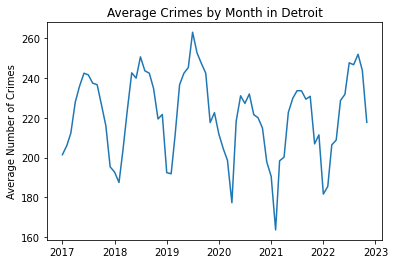

In [8]:
plt.plot(ts)
plt.title('Average Crimes by Month in Detroit')
plt.ylabel('Average Number of Crimes')
plt.show()

The time series plot appears to have a cyclical pattern in three year intervals with seasonal patterns peaking during the summer months and dipping during winter months. 

## Yearly Bar Plot

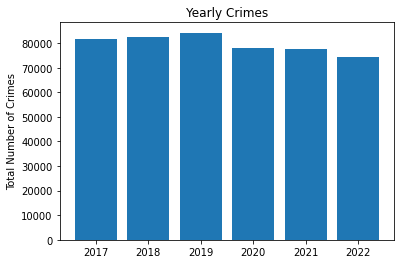

In [9]:
plt.bar(year_crime['year'], year_crime['number_of_crimes'])
plt.title('Yearly Crimes')
plt.ylabel('Total Number of Crimes')
plt.show();

## Average Crime Histogram

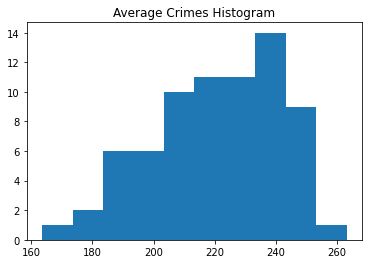

In [10]:
ts.hist()
plt.title('Average Crimes Histogram')
plt.grid(False)
plt.show()

## Lag Plot

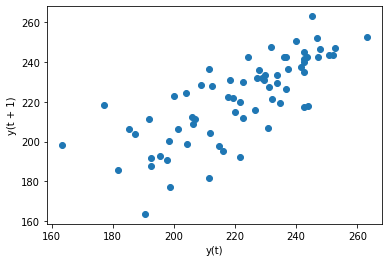

In [11]:
from pandas.plotting import lag_plot

lag_plot(ts)
plt.show()

There appears to be a positive correlation among the lag plot.

## Correlation

Creating lagged variables at different time steps
to determine if the values of the observation at the current and previous time steps are significant in predicting the future.

In [12]:
# extracting only average crime values
values = pd.DataFrame(ts.avg_crimes)
 
# using shift function to shift the values.
dataframe = pd.concat([values.shift(3), values.shift(2),
                       values.shift(1), values], axis=1)

dataframe.columns = ['t', 't+1', 't+2', 't+3']
 
result = dataframe.corr()
 
print(result)

            t       t+1       t+2       t+3
t    1.000000  0.769072  0.501006  0.111145
t+1  0.769072  1.000000  0.773342  0.488646
t+2  0.501006  0.773342  1.000000  0.763917
t+3  0.111145  0.488646  0.763917  1.000000


The values in the observation are significant for predicting the future.

## Autocorrelation Plot

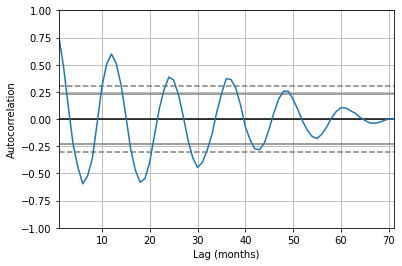

In [13]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(ts['avg_crimes']);
plt.xlabel('Lag (months)');

The autocorrelation identifies a clear indication of seasonality among the data.

# Time Series Models

The Time Series models will weigh heavily on Auto ARIMA, Auto-Regression, and SARIMA. The Auto ARIMA model is an automated configuration to the ***Auto-Regressive Integrated Moving Average (ARIMA)*** model. Another model that will be a focus which was indicated at a high level of seasonality is the ***Seasonal Auto-Regressive Integrated Moving Average (SARIMA)***. 

<br>

***Auto ARIMA*** finds the optimal order and the optimal seasonal order, based on determined criterion such as AIC, BIC, etc., and within the designated parameter restrictions, that fits the best model to a single variable (univariable) time series. While the ***Seasonal ARIMA (SARIMA)*** variant is a statistical model that can work with non-stationary data and capture some seasonality.

**Overview:**


*   Stationary Check
*   Base SARIMA Model
*   Single-Step SARIMA Model
*   AutoRegressive Model
*   Stepwise Auto ARIMA Model
*   Seasonal Decomposed ARIMA Model
*   Decomposed SARIMAX Model
*   Multi-Step SARIMA Model


In [14]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(ts.avg_crimes, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num of Lags : ", dftest[2])
print("4. Num of Observations used for ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.3959352749239056
2. P-Value :  0.5842232399888005
3. Num of Lags :  9
4. Num of Observations used for ADF Regression and Critical Values Calculation : 61
5. Critical Values :
	 1% :  -3.542412746661615
	 5% :  -2.910236235808284
	 10% :  -2.5927445767266866


With the p-value being larger than 0.05, we cannot reject the null hypothesis and the time series is not stationary.

### Training and Testing Split

Taking the most recent 14 periods as testing and the intial 57 periods as training.

In [15]:
#Spliting the dataset into train and test
ts_train = ts[:57]
ts_test = ts[-14:]

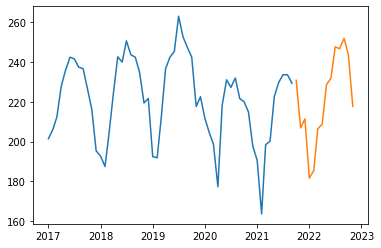

In [16]:
plt.plot(ts_train);
plt.plot(ts_test);

## Stationary Check

Checking if Time Series is stationary to determine if long-term forecasting is possible. 


In [17]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

def check_stationary(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [18]:
check_stationary(ts_train)

The series is NOT stationary


## Stationary Difference 

Since the Time Series is not stationary, it gets differenced and checked again for stationarity.



In [19]:
ts_diff = ts_train.diff()
ts_diff.dropna(inplace=True)
check_stationary(ts_diff)

The series is stationary


### Difference to Stationary Plot

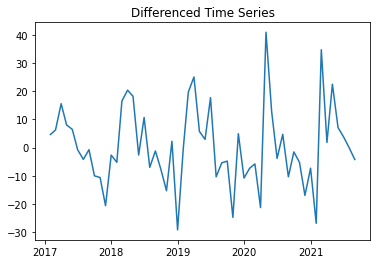

In [20]:
plt.plot(ts_diff)
plt.title('Differenced Time Series')
plt.show()

## Autocorrelation `(p,d,q)` Selection

The (P,D,Q,M) Order refers to the seasonal component of the model for the Auto Regressive parameters, differences, Moving Average parameters, and periodicity:

*   (**P**) indicates the Auto Regressive order for the seasonal component.

*   (**D**) indicates the integration order of the seasonal process (the number of transformations needed to make stationary the time series).

*   (**Q**) indicates the Moving Average order for the seasonal component.

*   (**M**) indicates the periodicity, i.e. the number of periods in season, such as 12 for monthly data.

Since the time series is now stationary, the difference order for the training model is set to 1. (`d=1`)



In [21]:
d = 1

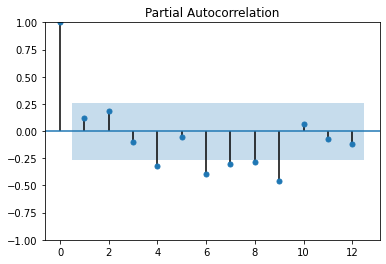

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(ts_diff, lags=12)
plt.show()

The maximum value of PACF out the confidence intervals is 9. (`p = 9`)

In [23]:
p = 9

Next, the Autocorrelation (ACF) graph will calculate the value of q.

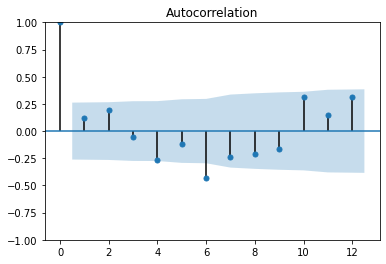

In [24]:
plot_acf(ts_diff, lags=12)
plt.show()

Looking at the acf, 6 is the most conservative and best leveraged. (`q=6`)

In [25]:
q = 6

## Base SARIMA

---
 
The **Seasonal Auto-Regressive Integrated Moving Average (SARIMA)** model, or **SARIMA(*p,d,q*)(*P,D,Q*)$_{m}$**, adds another set of parameters that takes into account periodic patterns when forecasting a time series, which is not always possible with an **ARIMA(*p,d,q*)** model.

In [26]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(ts_train, order=(p,d,q))
base_sarima_model_fit = model.fit()
base_sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             avg_crimes   No. Observations:                   57
Model:               SARIMAX(9, 1, 6)   Log Likelihood                -204.780
Date:                Mon, 12 Dec 2022   AIC                            441.559
Time:                        23:42:33   BIC                            473.965
Sample:                    01-01-2017   HQIC                           454.123
                         - 09-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6784      0.424     -1.600      0.110      -1.509       0.153
ar.L2         -0.2933      0.402     -0.730      0.465      -1.080       0.494
ar.L3          0.0143      0.510      0.028      0.978      -0.985       1.013
ar.L4         -0.0773      0.349     -0.221      0.825      -0.762       0.607
ar.L5         -0.3631      0.344     -1.056      0.291      -1.037       0.311
ar.L6         -0.8369      0.335     -2.501      0.012      -1.493      -0.181
ar.L7         -0.3752      0.286     -1.312      0.189      -0.936       0.185
ar.L8         -0.3143      0.233     -1.350      0.177      -0.771       0.142
ar.L9         -0.4757      0.205     -2.318      0.020      -0.878      -0.073
ma.L1          0.4039      0.754      0.536      0.592      -1.073       1.881
ma.L2         -0.0616      1.760     -0.035      0.972      -3.511       3.388
ma.L3         -0.4458      0.627     -0.711      0.477      -1.674       0.782
ma.L4         -0.0698      1.656     -0.042      0.966      -3.315       3.176
ma.L5          0.4061      1.000      0.406      0.685      -1.554       2.366
ma.L6          0.8988      1.440      0.624      0.533      -1.924       3.721
sigma2        71.1447     88.095      0.808      0.419    -101.519     243.808
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 6.26
Prob(Q):                              0.66   Prob(JB):                         0.04
Heteroskedasticity (H):               2.71   Skew:                            -0.59
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

According to the model summary, the model meets the condition of independence in the residuals (no correlation) because the p-value of the Ljung-Box test (`Prob(Q): 0.66`) is greater than 0.05, so we cannot reject the null hypothesis of independence, but we cannot say that the residual distribution is homoscedastic (constant variance) because the p-value of the Heteroskedasticity test (`Prob(H): 0.04`) is smaller than 0.05.

NormaltestResult(statistic=113.60945887433616, pvalue=2.1380578873051365e-25)


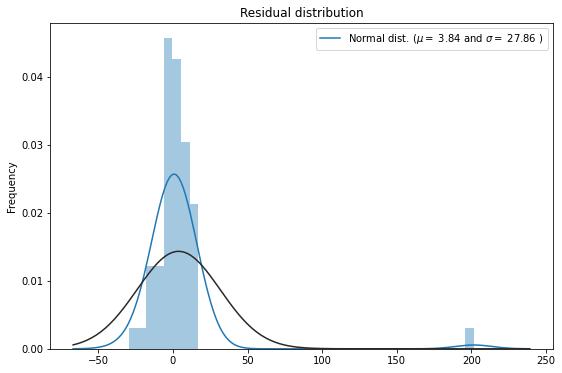

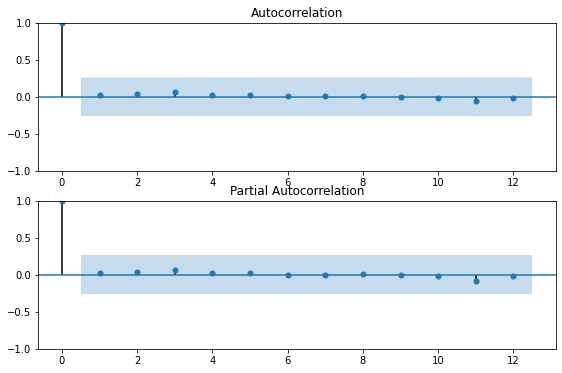

In [27]:
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns
import statsmodels.api as sm

resid = base_sarima_model_fit.resid
print(normaltest(resid))

fig = plt.figure(figsize=(9,6))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) 

(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(9.27,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(base_sarima_model_fit.resid, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(base_sarima_model_fit.resid, lags=12, ax=ax2)

The graph does pass the eye test for a normal distribution. With the mean of 3.45 and standard deviation of 27.86 the model is not distributed normally. There is also no correlation among the PACF.

In [28]:
n_test = ts_test.shape[0]
base_sarima_pred = base_sarima_model_fit.forecast(steps=n_test)

### Base SARIMAX Prediction

In [29]:
def SMAPE(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast)))

In [30]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import numpy as np

base_sarima_pred_score = pd.DataFrame(base_sarima_pred)
nrmse = rmse(base_sarima_pred_score, ts_test)/(np.max(ts_test)-np.min(ts_test))
smape = SMAPE(ts_test.avg_crimes, base_sarima_pred)


print("MSE: {}".format(round(mean_squared_error(ts_test, base_sarima_pred_score), 3)))
print("Normalized RMSE: {}".format(nrmse.to_string(index=False, header=False)))
print("R^2: {}".format(round(r2_score(ts_test, base_sarima_pred_score), 6)))
print("SMAPE: {}". format(round(smape, 6)))

MSE: 202.843
Normalized RMSE: 0.202248
R^2: 0.570539
SMAPE: 0.057084


### Base SARIMA Prediction Plot

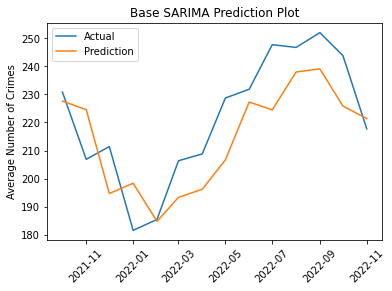

In [31]:
plt.plot(ts_test, label='Actual')
plt.plot(base_sarima_pred_score, label='Prediction')
plt.title('Base SARIMA Prediction Plot')
plt.ylabel('Average Number of Crimes')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Base SARIMA Forecast

In [32]:
# The forecast will be 200 periods (months) out
N = 200
base_sarima_forecast = base_sarima_model_fit.forecast(steps=n_test+N)

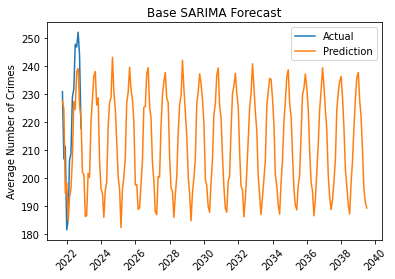

In [33]:
plt.plot(ts_test, label='Actual')
plt.plot(base_sarima_forecast, label='Prediction')
plt.title('Base SARIMA Forecast')
plt.ylabel('Average Number of Crimes')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Single-Step SARIMA

---

Implementing a single-step to fit the forecast following the (*p,d,q*) order, to iterate through the series.

In [34]:
ts_train_step = ts_train
ts_pred_step = pd.Series()

for i in range(0, n_test):
    model_step = SARIMAX(ts_train_step.avg_crimes, order=(p,d,q))
    model_step_fit = model_step.fit()
    current_pred = model_step_fit.forecast(steps=1)
    ts_train_step = ts_train_step.append(current_pred, ignore_index=True)
    ts_pred_step = ts_pred_step.append(current_pred)

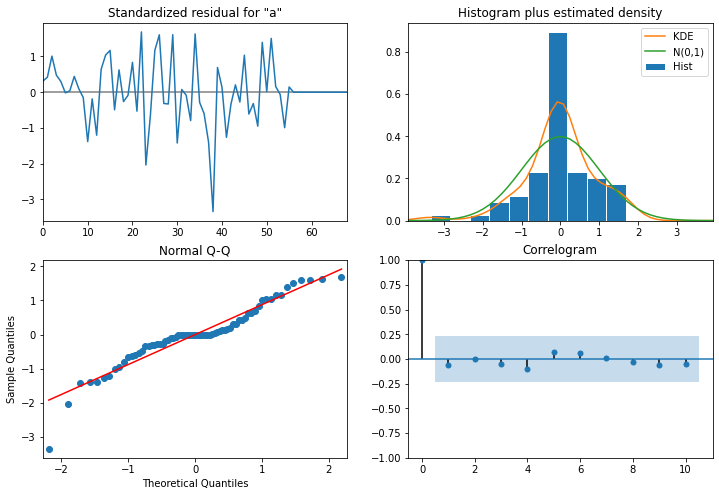

In [35]:
model_step_fit.plot_diagnostics(figsize=(12,8))
plt.show()

The standardized residual plot depicts variance change around a mean of zero with uniform variance. While the normal Q-Q plot demonstrates that the residuals do not follow a normal distribution with slight normality and skewed tails.The Correlogram does not show any significant correlation in the residuals. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. 

### Single-Step SARIMA Prediction

In [36]:
ts_pred_step_score = pd.DataFrame(ts_pred_step)
nrmse = rmse(ts_pred_step_score, ts_test)/(np.max(ts_test)-np.min(ts_test))
smape = SMAPE(ts_test.avg_crimes, ts_pred_step)

print("MSE: {}".format(round(mean_squared_error(ts_test, ts_pred_step), 3)))
print("Normalized RMSE: {}".format(nrmse.to_string(index=False, header=False)))
print("R^2: {}".format(round(r2_score(ts_test, ts_pred_step), 6)))
print("SMAPE: {}". format(round(smape, 6)))

MSE: 198.395
Normalized RMSE: 0.200018
R^2: 0.579956
SMAPE: 0.00101


### Single-Step SARIMA Prediction Plot

In [37]:
#Creating Time Series Prediction Step scoring frame into DataFrame
tsps = pd.DataFrame(ts_pred_step)
tsps = tsps.values
tsps = pd.DataFrame(tsps)

ts_date = base_sarima_pred.index
ts_date = pd.DataFrame(ts_date)

ts_pred_step_df = pd.concat([ts_date, tsps], join = 'outer', axis = 1)
ts_pred_step_df.columns = ['time', 'avg_crimes']
ts_pred_step_df = ts_pred_step_df.set_index(pd.DatetimeIndex(ts_pred_step_df['time']))
ts_pred_step_df = ts_pred_step_df.drop('time', axis=1)

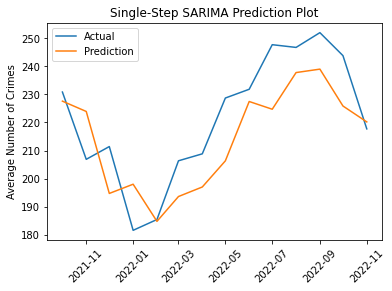

In [38]:
plt.plot(ts_test, label='Actual')
plt.plot(ts_pred_step_df, label='Prediction')
plt.title('Single-Step SARIMA Prediction Plot')
plt.ylabel('Average Number of Crimes')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Single-Step SARIMA Forecast

In [39]:
ts_pred_forecast = model_step_fit.forecast(steps=n_test+N)

In [40]:
# Create scoring dataframe

tsps = pd.DataFrame(ts_pred_forecast)
tsps = tsps.values
tsps = pd.DataFrame(tsps)

ts_date = base_sarima_forecast.index
ts_date = pd.DataFrame(ts_date)

single_step_forecast = pd.concat([ts_date, tsps], join = 'outer', axis = 1)
single_step_forecast.columns = ['time', 'avg_crimes']
single_step_forecast = single_step_forecast.set_index(pd.DatetimeIndex(single_step_forecast['time']))
single_step_forecast = single_step_forecast.drop('time', axis=1)

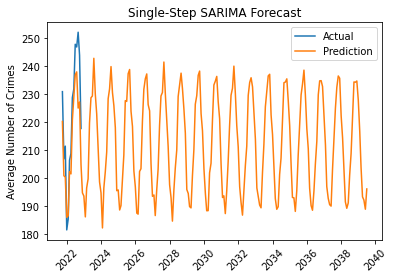

In [41]:
plt.plot(ts_test, label='Actual')
plt.plot(single_step_forecast, label='Prediction')
plt.title('Single-Step SARIMA Forecast')
plt.ylabel('Average Number of Crimes')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## AutoRegressive

---

Autoregression modeling is a modeling technique used for time series data that assumes linear continuation of the series so that previous values in the time series can be used to predict futures values. The previous time step(s) is useful in predicting the value at the next time step (dependance between values).

In [42]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score

model = AutoReg(ts_train, lags=12)
ar_model_fit = model.fit()
print(ar_model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:             avg_crimes   No. Observations:                   57
Model:                    AutoReg(12)   Log Likelihood                -168.969
Method:               Conditional MLE   S.D. of innovations             10.339
Date:                Mon, 12 Dec 2022   AIC                            365.937
Time:                        23:43:58   BIC                            391.230
Sample:                    01-01-2018   HQIC                           375.366
                         - 09-01-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             35.3943     48.996      0.722      0.470     -60.637     131.425
avg_crimes.L1      0.6856      0.146      4.686      0.000       0.399       0.972
avg_crimes.L2      0.1049      0.176

NormaltestResult(statistic=0.2144493623686411, pvalue=0.8983238138557795)


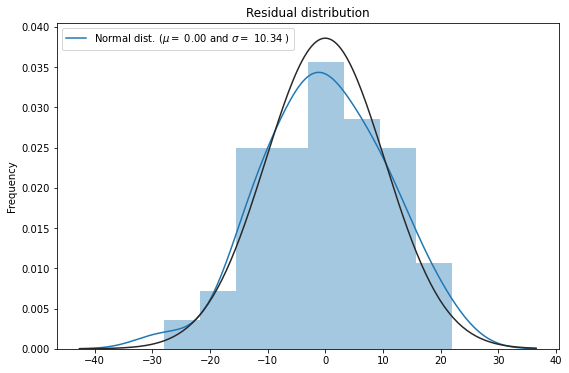

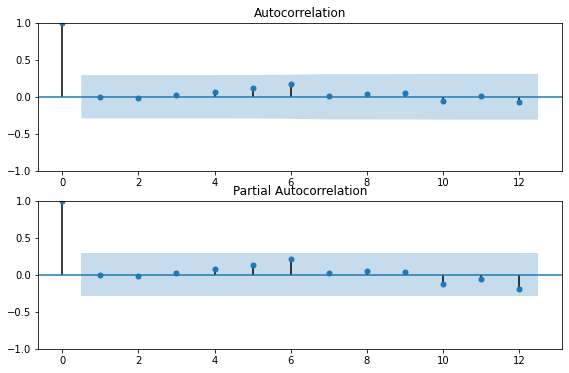

In [43]:
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns
import statsmodels.api as sm

resid = ar_model_fit.resid
print(normaltest(resid))

fig = plt.figure(figsize=(9,6))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) 

(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(9.38,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ar_model_fit.resid, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ar_model_fit.resid, lags=12, ax=ax2)

The p-value is higher than 0.05, meaning the residual is a normal distribution. The distribuiton plot also confirms this. The Autocorrelation shows that the Time Series residuals have low correlation with lagged versions of itself. 

In [44]:
n_test = ts_test.shape[0]
ar_pred = ar_model_fit.forecast(steps=n_test)

### AutoRegressive Prediction

In [45]:
ar_pred_score = pd.DataFrame(ar_pred)
nrmse = rmse(ar_pred_score, ts_test)/(np.max(ts_test)-np.min(ts_test))
smape = SMAPE(ts_test.avg_crimes, ar_pred)


print("MSE: {}".format(round(mean_squared_error(ts_test, ar_pred_score), 3)))
print("Normalized RMSE: {}".format(nrmse.to_string(index=False, header=False)))
print("R^2: {}".format(round(r2_score(ts_test, ar_pred_score), 6)))
print("SMAPE: {}". format(round(smape, 6)))

MSE: 184.115
Normalized RMSE: 0.192685
R^2: 0.61019
SMAPE: 0.051873


### AutoRegressive Prediction Plot

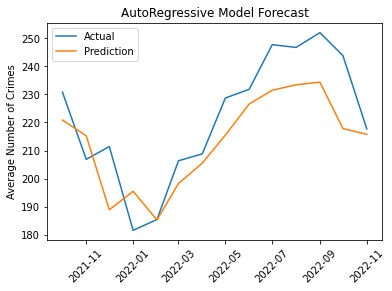

In [46]:
plt.plot(ts_test, label='Actual')
plt.plot(ar_pred, label='Prediction')
plt.title('AutoRegressive Model Forecast')
plt.ylabel('Average Number of Crimes')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### AutoRegressive Forecast

In [47]:
ar_forecast = ar_model_fit.forecast(steps=n_test+N)

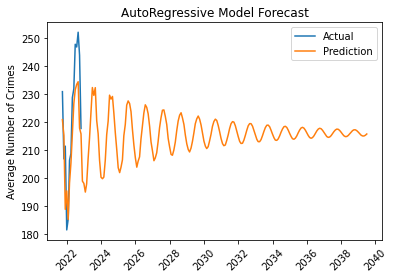

In [48]:
plt.plot(ts_test, label='Actual')
plt.plot(ar_forecast, label='Prediction')
plt.title('AutoRegressive Model Forecast')
plt.ylabel('Average Number of Crimes')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Stepwise Auto ARIMA 

---

In [49]:
import pmdarima as pm

stepwise_model = pm.auto_arima(ts_train, 
                               start_p=1, d=1, start_q=1,
                               max_p=12, max_q=12, 
                               m=12,
                               seasonal=True, 
                               stationary=False,
                               information_criterion='aic',
                               stepwise=False, 
                               suppress_warnings=True)

stepwise_model.fit(ts_train)
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -222.662
Date:                              Mon, 12 Dec 2022   AIC                            453.325
Time:                                      23:45:02   BIC                            461.426
Sample:                                  01-01-2017   HQIC                           456.466
                                       - 09-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.152      0.004      0.997      -0.298       0.299
ar.S.L12       0.9581      0.255      3.764      0.000       0.459       1.457
ma.S.L12      -0.7831      0.684     -1.145      0.252      -2.124       0.558
sigma2       145.5886     52.981      2.748      0.006      41.748     249.429
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):                 2.26
Prob(Q):                              0.29   Prob(JB):                         0.32
Heteroskedasticity (H):               3.05   Skew:                            -0.11
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Same situation with this model summary, the model meets the condition of independence in the residuals because the p-value of the Ljung-Box test (`Prob(Q): 0.29`) is greater than 0.05, so we cannot reject the null hypothesis of independence, but we cannot say that the residual distribution is homoscedastic because the p-value of the Heteroskedasticity test (`Prob(H): 0.02`) is smaller than 0.05.

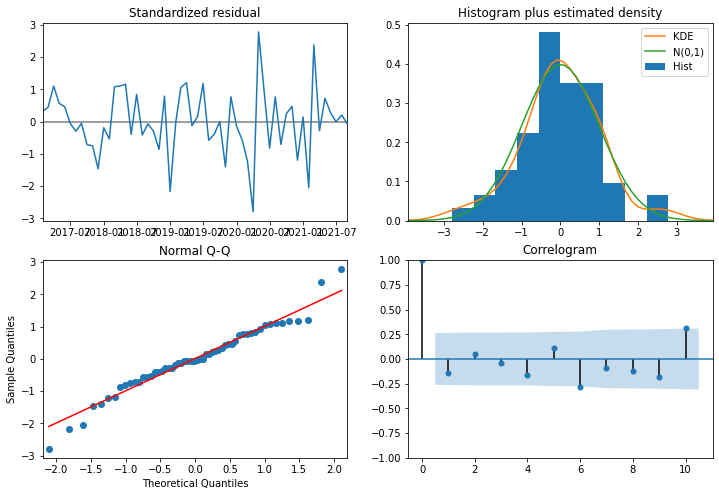

In [50]:
stepwise_model.plot_diagnostics(figsize=(12,8))
plt.show()

The standardized residual plot depicts variance change around a mean of zero with uniform variance. The Correlogram does not show any significant correlation in the residuals again. The standardized residual plot depicts variance change again as well, while the normal Q-Q plot demonstrates that the residuals do not follow a normal distribution with skewe tails.

In [51]:
ts_pred_auto = stepwise_model.predict(n_periods=n_test)

### Stepwise Auto ARIMA Prediction

In [52]:
ts_pred_auto_score = pd.DataFrame(ts_pred_auto)
nrmse = rmse(ts_pred_auto_score, ts_test)/(np.max(ts_test)-np.min(ts_test))
smape = SMAPE(ts_test.avg_crimes, ts_pred_auto)

print("MSE: {}".format(round(mean_squared_error(ts_test, ts_pred_auto), 3)))
print("RMSE: {}".format(nrmse.to_string(index=False, header=False)))
print("R^2: {}".format(round(r2_score(ts_test, ts_pred_auto), 6)))
print("SMAPE: {}". format(round(smape, 6)))

MSE: 139.009
RMSE: 0.167427
R^2: 0.705689
SMAPE: 0.040223


### Stepwise Auto ARIMA Prediction Plot

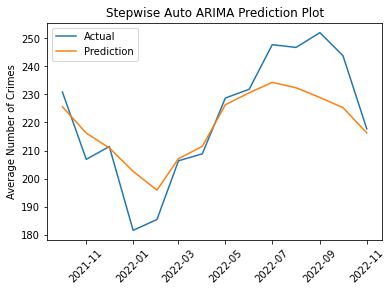

In [53]:
plt.plot(ts_test, label='Actual')
plt.plot(ts_test.index, ts_pred_auto, label='Prediction')
plt.title('Stepwise Auto ARIMA Prediction Plot')
plt.ylabel('Average Number of Crimes')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Stepwise Auto ARIMA Forecast

In [54]:
stepwise_forecast = stepwise_model.predict(n_periods=n_test+N)

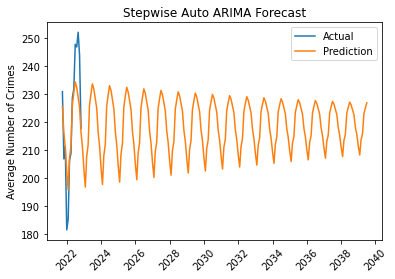

In [55]:
plt.plot(ts_test, label='Actual')
plt.plot(stepwise_forecast, label='Prediction')
plt.title('Stepwise Auto ARIMA Forecast')
plt.ylabel('Average Number of Crimes')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Seasonal Decomposition Analysis

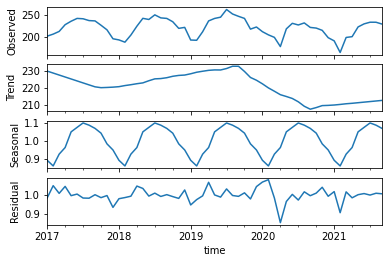

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig, axes = plt.subplots(4, 1, sharex=True)

ts_decomposed = seasonal_decompose(ts_train, model='multiplicative', extrapolate_trend=True)
ts_trend = ts_decomposed.trend
ts_seasonal = ts_decomposed.seasonal
ts_residual = ts_decomposed.resid

ts_decomposed.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed');
ts_decomposed.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend');
ts_decomposed.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal');
ts_decomposed.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual');

Here we can see that the range of trend and residual is marginal. The trend has a variation between 210 to 230, and most of the time residual is having the variation around 1.0. We can observe the seasonality varies between 0.9 to 1.1, which is a very low difference range.

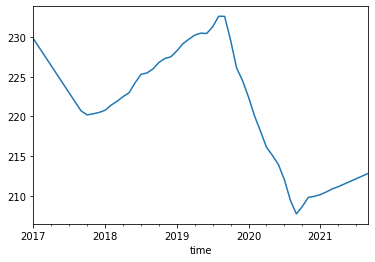

In [57]:
seasonality=ts_decomposed.trend
seasonality.plot();

### Trend Stationary Check

In [58]:
check_stationary(ts_trend)

The series is NOT stationary


In [59]:
ts_trend_diff = ts_trend.diff()
ts_trend_diff.dropna(inplace=True)
check_stationary(ts_trend_diff)

The series is stationary


In [60]:
d = 1

## Decomposed Auto ARIMA

---

In [61]:
stepwise_decompose_model = pm.auto_arima(ts_trend,
                                         start_p=1, d=d, start_q=1,
                                         max_p=12, max_q=12, 
                                         m=12,
                                         seasonal=False, 
                                         stationary=False,
                                         information_criterion='aic',
                                         stepwise=False, 
                                         suppress_warnings=True)

stepwise_decompose_model.fit(ts_trend)
trend_pred_auto = stepwise_decompose_model.predict(n_periods=n_test)

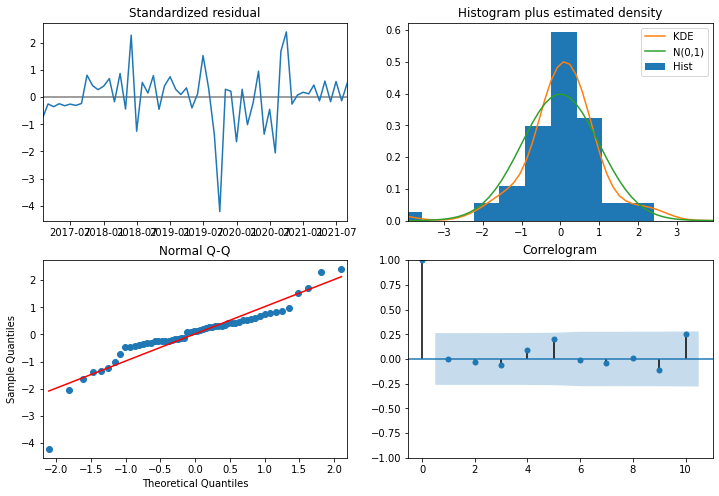

In [62]:
stepwise_decompose_model.plot_diagnostics(figsize=(12,8))
plt.show()

The residual errors fluctuate around a mean of zero and have a uniform variance. The since the residuals don't line up on the qq plot, it indicates that the distribution has a skewed tail. The Correlogram, shows the residual errors are not autocorrelated. 

### Seasonal Stationary Check

In [63]:
check_stationary(ts_seasonal)

The series is stationary


In [64]:
d = 1

In [65]:
stepwise_seasonal_auto_model = pm.auto_arima(ts_seasonal, 
                               start_p=1, d=d, start_q=1,
                               max_p=12, max_q=12, 
                               m=12,
                               seasonal=True, 
                               stationary=True,
                               information_criterion='aic',
                               stepwise=True,
                               suppress_warnings=True)

stepwise_seasonal_auto_model.fit(ts_seasonal)
seasonal_pred_auto = stepwise_seasonal_auto_model.predict(n_periods=n_test)

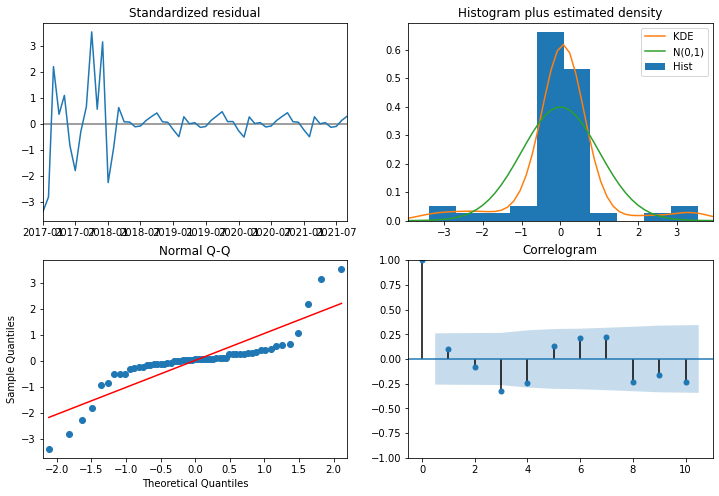

In [66]:
stepwise_seasonal_auto_model.plot_diagnostics(figsize=(12,8))
plt.show()

The residuals over time are shown and imply the residuals have seasonality.The qq-plot does not follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). This is a strong indication that the residuals are not normally distributed. The Correlogram, shows the residual errors are not autocorrelated.

In [67]:
ts_pred_decompose = trend_pred_auto * seasonal_pred_auto 

### Decomposed Auto ARIMA Prediction

In [68]:
ts_pred_decompose_score = pd.DataFrame(ts_pred_decompose)
nrmse = rmse(ts_pred_decompose_score, ts_test)/(np.max(ts_test)-np.min(ts_test))
smape = SMAPE(ts_test.avg_crimes, ts_pred_decompose)

print("MSE: {}".format(round(mean_squared_error(ts_test, ts_pred_decompose), 3)))
print("RMSE: {}".format(nrmse.to_string(index=False, header=False)))
print("R^2: {}".format(round(r2_score(ts_test, ts_pred_decompose), 6)))
print("SMAPE: {}". format(round(smape, 6)))

MSE: 156.483
RMSE: 0.177639
R^2: 0.668692
SMAPE: 0.045718


### Decomposed Auto ARIMA Prediction Plot

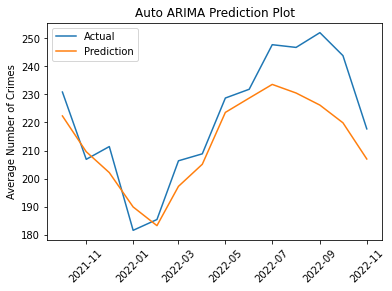

In [69]:
plt.plot(ts_test, label='Actual')
plt.plot(ts_test.index, ts_pred_decompose, label='Prediction')
plt.title('Auto ARIMA Prediction Plot')
plt.ylabel('Average Number of Crimes')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Decomposed Auto ARIMA Forecast

In [70]:
ts_season_pred = stepwise_seasonal_auto_model.fit(ts_seasonal)
seasonal_forecast = ts_season_pred.predict(n_periods=n_test+N)

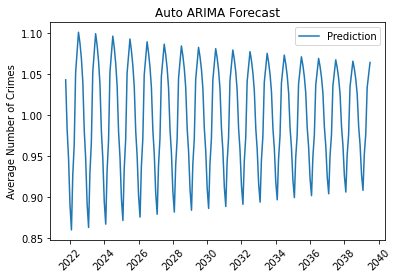

In [71]:
plt.plot(seasonal_forecast, label='Prediction')
plt.title('Auto ARIMA Forecast')
plt.ylabel('Average Number of Crimes')
plt.xticks(rotation=45)
plt.legend()
plt.show()

The seasonal decomposed effect from Auto ARIMA proves to reflect a decent impact to long-term forecasting of seasonality. 

### Seasonal Decomposition Additive Analysis

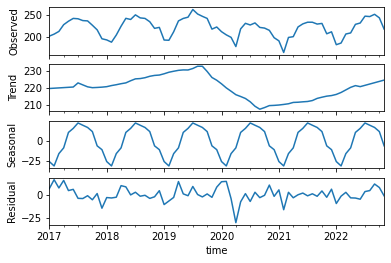

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig, axes = plt.subplots(4, 1, sharex=True)

result = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed');
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend');
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal');
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual');

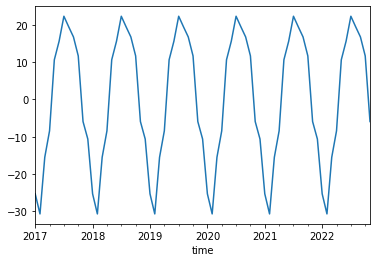

In [73]:
seasonality = result.seasonal
seasonality.plot();

We can see clearly there is seasonality among the decomposition.

In [74]:
seasonal = result.seasonal
check_stationary(seasonal)

The series is stationary


Here the series is already stationary. No need to difference the seasonal order. (`D = 0`)

In [75]:
D = 0

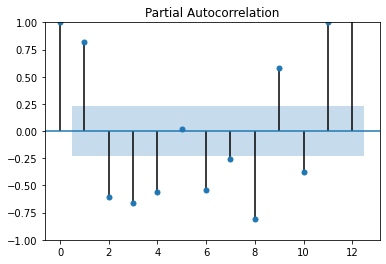

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal, lags=12)
plt.show()

In the PACF graph the maximum value out the confidence intervals (in light blue) is 12, thus we can set (`P = 12`)

In [77]:
P = 12

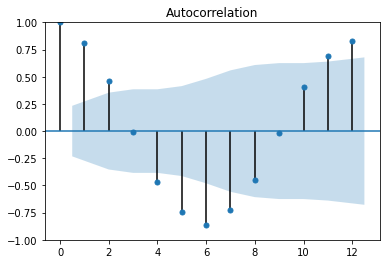

In [78]:
plot_acf(seasonal, lags=12)
plt.show()

From the above graph, we note that the maximum value out the confidence intervals is 8. (`Q = 8`)

In [79]:
Q = 8

## Decomposed SARIMA

---

In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

seasonal_model = SARIMAX(ts_train, order=(p,d,q))
seasonal_model_fit = seasonal_model.fit()
seasonal_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             avg_crimes   No. Observations:                   57
Model:               SARIMAX(9, 1, 6)   Log Likelihood                -204.780
Date:                Mon, 12 Dec 2022   AIC                            441.559
Time:                        23:57:33   BIC                            473.965
Sample:                    01-01-2017   HQIC                           454.123
                         - 09-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6784      0.424     -1.600      0.110      -1.509       0.153
ar.L2         -0.2933      0.402     -0.730      0.465      -1.080       0.494
ar.L3          0.0143      0.510      0.028      0.978      -0.985       1.013
ar.L4         -0.0773      0.349     -0.221      0.825      -0.762       0.607
ar.L5         -0.3631      0.344     -1.056      0.291      -1.037       0.311
ar.L6         -0.8369      0.335     -2.501      0.012      -1.493      -0.181
ar.L7         -0.3752      0.286     -1.312      0.189      -0.936       0.185
ar.L8         -0.3143      0.233     -1.350      0.177      -0.771       0.142
ar.L9         -0.4757      0.205     -2.318      0.020      -0.878      -0.073
ma.L1          0.4039      0.754      0.536      0.592      -1.073       1.881
ma.L2         -0.0616      1.760     -0.035      0.972      -3.511       3.388
ma.L3         -0.4458      0.627     -0.711      0.477      -1.674       0.782
ma.L4         -0.0698      1.656     -0.042      0.966      -3.315       3.176
ma.L5          0.4061      1.000      0.406      0.685      -1.554       2.366
ma.L6          0.8988      1.440      0.624      0.533      -1.924       3.721
sigma2        71.1447     88.095      0.808      0.419    -101.519     243.808
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 6.26
Prob(Q):                              0.66   Prob(JB):                         0.04
Heteroskedasticity (H):               2.71   Skew:                            -0.59
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Again the model meets the condition of independence in the residuals because the p-value of the Ljung-Box test (`Prob(Q): 0.66`) is greater than 0.05, so we cannot reject the null hypothesis of independence. We also cannot say that the residual distribution is homoscedastic because the p-value of the Heteroskedasticity test (`Prob(H): 0.04`) is smaller than 0.05.

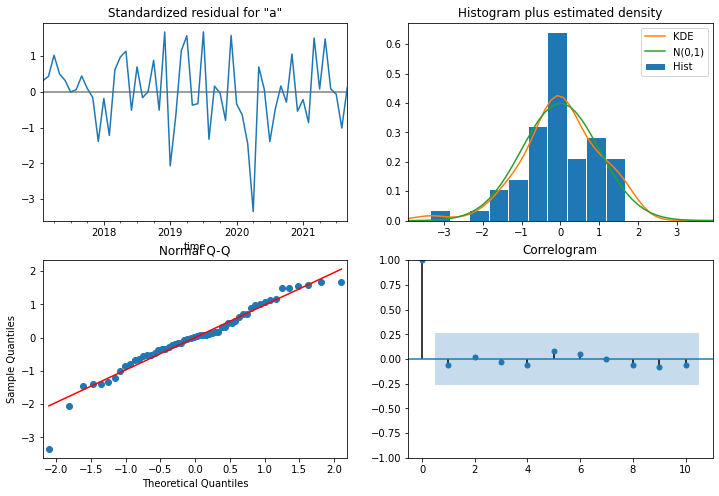

In [81]:
seasonal_model_fit.plot_diagnostics(figsize=(12,8))
plt.show()

The standardized residual errors seem to fluctuate around a mean of zero and have a uniform variance. The density plot suggest normal distribution with mean zero and overlapping N(0,1). The Q-Q plot of the residuals implies that the residuals follow a linear trend with skewed tails. Thus, the residuals are normally distributed. The Correlogram, plot shows the residual errors are not autocorrelated.

In [82]:
n_test = ts_test.shape[0]
seasonal_pred = seasonal_model_fit.forecast(steps=n_test)

### Decomposed SARIMA Prediction

In [83]:
seasonal_pred_score = pd.DataFrame(seasonal_pred)
nrmse = rmse(seasonal_pred_score, ts_test)/(np.max(ts_test)-np.min(ts_test))
smape = SMAPE(ts_test.avg_crimes, seasonal_pred)

print("MSE: {}".format(round(mean_squared_error(ts_test, seasonal_pred), 3)))
print("RMSE: {}".format(nrmse.to_string(index=False, header=False)))
print("R^2: {}".format(round(r2_score(ts_test, seasonal_pred), 6)))
print("SMAPE: {}". format(round(smape, 6)))

MSE: 202.843
RMSE: 0.202248
R^2: 0.570539
SMAPE: 0.057084


### Decomposed SARIMA Prediction Plot

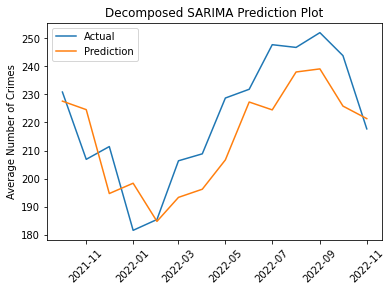

In [84]:
plt.plot(ts_test, label='Actual')
plt.plot(ts_test.index, seasonal_pred, label='Prediction')
plt.title('Decomposed SARIMA Prediction Plot')
plt.ylabel('Average Number of Crimes')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Decomposed SARIMA Forecast

In [85]:
seasonal_sarima_forecast = seasonal_model_fit.forecast(steps=n_test+N)

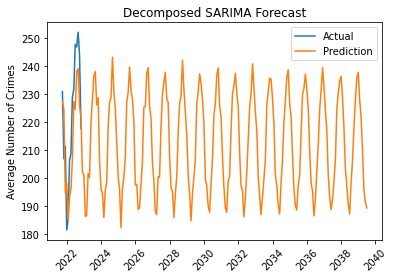

In [86]:
plt.plot(ts_test, label='Actual')
plt.plot(seasonal_sarima_forecast, label='Prediction')
plt.title('Decomposed SARIMA Forecast')
plt.ylabel('Average Number of Crimes')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Multi-Step Decomposed SARIMA

---

In [87]:
model_seasonal = SARIMAX(ts_train, order=(p,d,q), seasonal_order=(P,D,Q,12))
model_fit_seasonal = model_seasonal.fit()
model_fit_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                 SARIMAX Results                                                  
==================================================================================================================
Dep. Variable:                                                 avg_crimes   No. Observations:                   57
Model:             SARIMAX(9, 1, 6)x(12, 0, [1, 2, 3, 4, 5, 6, 7, 8], 12)   Log Likelihood                -202.422
Date:                                                    Tue, 13 Dec 2022   AIC                            476.843
Time:                                                            00:01:23   BIC                            549.756
Sample:                                                        01-01-2017   HQIC                           505.111
                                                             - 09-01-2021                                         
Covariance Type:                                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7544      3.047     -0.248      0.804      -6.726       5.217
ar.L2         -0.3967      8.304     -0.048      0.962     -16.673      15.879
ar.L3         -0.0790      4.082     -0.019      0.985      -8.080       7.922
ar.L4         -0.0707      9.479     -0.007      0.994     -18.650      18.508
ar.L5         -0.3158      3.815     -0.083      0.934      -7.793       7.162
ar.L6         -0.8272      5.454     -0.152      0.879     -11.516       9.862
ar.L7         -0.4928      1.983     -0.248      0.804      -4.380       3.394
ar.L8         -0.4103      2.695     -0.152      0.879      -5.693       4.872
ar.L9         -0.5465      4.648     -0.118      0.906      -9.657       8.564
ma.L1          0.4141      4.296      0.096      0.923      -8.006       8.834
ma.L2         -0.0730      4.473     -0.016      0.987      -8.840       8.694
ma.L3         -0.3471      5.144     -0.067      0.946     -10.429       9.735
ma.L4         -0.0265      4.131     -0.006      0.995      -8.124       8.071
ma.L5          0.4325      6.749      0.064      0.949     -12.795      13.659
ma.L6          0.9116      7.403      0.123      0.902     -13.597      15.421
ar.S.L12      -0.1116   1834.079  -6.08e-05      1.000   -3594.840    3594.617
ar.S.L24       0.0759    550.158      0.000      1.000   -1078.214    1078.366
ar.S.L36       0.3806   1246.037      0.000      1.000   -2441.808    2442.569
ar.S.L48       0.1899    789.296      0.000      1.000   -1546.802    1547.182
ar.S.L60       0.2009   1331.493      0.000      1.000   -2609.477    2609.879
ar.S.L72       0.0492    714.288   6.88e-05      1.000   -1399.930    1400.028
ar.S.L84      -0.1732   2184.443  -7.93e-05      1.000   -4281.604    4281.257
ar.S.L96      -0.1912   1160.057     -0.000      1.000   -2273.860    2273.478
ar.S.L108     -0.1507   1918.738  -7.85e-05      1.000   -3760.809    3760.508
ar.S.L120      0.0216   2479.574   8.69e-06      1.000   -4859.855    4859.898
ar.S.L132      0.0921   3025.476   3.05e-05      1.000   -5929.732    5929.916
ar.S.L144      0.1035    867.946      0.000      1.000   -1701.039    1701.246
ma.S.L12      -0.0608   1660.194  -3.66e-05      1.000   -3253.981    3253.860
ma.S.L24      -0.0794    724.125     -0.000      1.000   -1419.338    1419.179
ma.S.L36       0.2451   1318.586      0.000      1.000   -2584.136    2584.626
ma.S.L48      -0.0836   2462.461  -3.39e-05      1.000   -4826.418    4826.251
ma.S.L60      -0.0982   1208.073  -8.13e-05      1.000   -2367.877    2367.681
ma.S.L72      -0.1208    650.225     -0.000      1.000   -1274.539    1274.297
ma.S.L84      -0.0341   1652.688  -2.06e-05      1.000   -3239.243    323

The Multi-Step SARIMA model meets the condition of independence in the residuals because the p-value of the Ljung-Box test (`Prob(Q): 0.09`) is greater than 0.05, so we cannot reject the null hypothesis of independence. This time the residual distribution is homoscedastic because the p-value of the Heteroskedasticity test (`Prob(H): 0.05`) is equal than 0.05 indicating that the model explains better the variance in the data. This model outperforms the previous ones in terms of dependability. This demonstrates that SARIMA is superior for short-term forecasting.

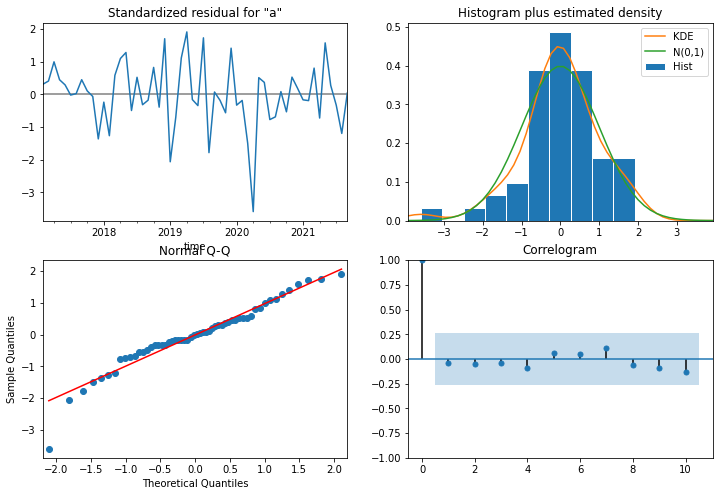

In [88]:
model_fit_seasonal.plot_diagnostics(figsize=(12,8))
plt.show()

Again, the plots show that the residuals are not correlated. The standardized residuals model seems similar to the previous one but as we have seen in the model summary this model is more reliable because we can't reject the null hypothesis of homoscedasticity. The qq-plot follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). This is a strong indication that the residuals are normally distributed.

### Multi-Step Decomposed SARIMA Prediction

In [89]:
ts_pred_seasonal = model_fit_seasonal.forecast(steps=n_test)

In [90]:
ts_pred_seasonal_score = pd.DataFrame(ts_pred_seasonal)
seasonal_nrmse = rmse(ts_pred_seasonal_score, ts_test)/(np.max(ts_test)-np.min(ts_test))
smape = SMAPE(ts_test.avg_crimes, ts_pred_seasonal)

print("MSE: {}".format(round(mean_squared_error(ts_test, ts_pred_seasonal), 3)))
print("Normalized RMSE: {}".format(seasonal_nrmse.to_string(index=False, header=False)))
print("R^2: {}".format(round(r2_score(ts_test, ts_pred_seasonal),6)))
print("SMAPE: {}". format(round(smape, 6)))

MSE: 150.764
Normalized RMSE: 0.174362
R^2: 0.680801
SMAPE: 0.048841


### Multi-Step Decomposed SARIMA Prediction Plot

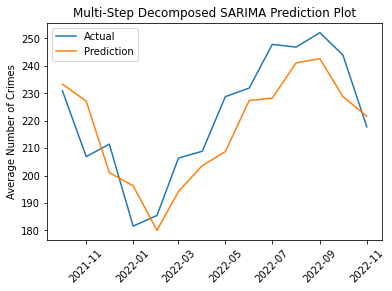

In [91]:
plt.plot(ts_test, label='Actual')
plt.plot(ts_test.index, ts_pred_seasonal, label='Prediction')
plt.title('Multi-Step Decomposed SARIMA Prediction Plot')
plt.ylabel('Average Number of Crimes')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Multi-Step Decomposed SARIMA Forecast

In [92]:
multi_seasonal_forecast = model_fit_seasonal.forecast(steps=n_test+N)

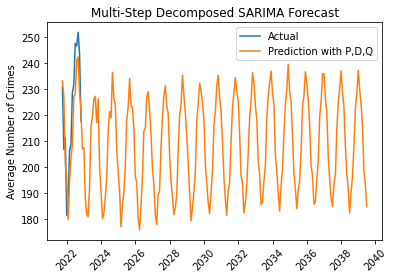

In [93]:
plt.plot(ts_test, label='Actual')
plt.plot(multi_seasonal_forecast, label='Prediction with P,D,Q')
plt.title('Multi-Step Decomposed SARIMA Forecast')
plt.ylabel('Average Number of Crimes')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Prediction Results

<center>

|          Model                 |   MSE   |  NRMSE  |   R^2  |   SMAPE  |
| :----------------------------: | :-----: | :----: | :----: |  :-----: |
|         Base SARIMA            | 202.843 | 20.22%    | 57.05% |   5.70%  |
|      Single-Step SARIMA        | 198.395 | 20.00%    | 57.99% |   0.10%  |
|         AutoRegressive         | 184.115 | 19.26%    | 61.01% |   5.18%  |
|      Stepwise Auto ARIMA       | 139.009 | 16.74%    | 70.56% |   4.02%  |
| Seasonal Decomposed Auto ARIMA | 156.438 | 17.76%    | 66.86% |   4.57%  |
|  Decomposed SARIMA             | 202.843 | 20.22%    | 57.05% |   5.70%  |
| Multi-Step Decomposed SARIMA   | 150.765 | 17.43%    | 68.08% |   4.88%  |

</center>



# Prediction Plot Analysis


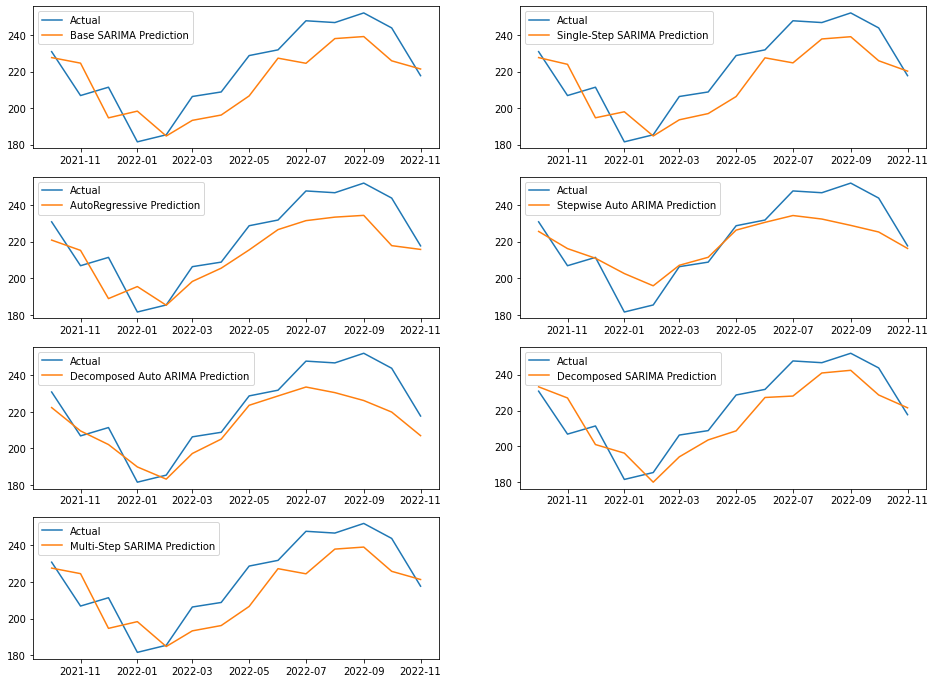

In [94]:
from matplotlib import pyplot as PLT
plt.rcParams["figure.figsize"] = (16,12)

fig = PLT.figure()

ax1 = fig.add_subplot(421)
ax1.plot(ts_test, label='Actual')
ax1.plot(base_sarima_pred_score, label='Base SARIMA Prediction')
ax1.legend()

ax2 = fig.add_subplot(422)
ax2.plot(ts_test, label='Actual')
ax2.plot(ts_pred_step_df, label='Single-Step SARIMA Prediction')
ax2.legend()

ax3 = fig.add_subplot(423)
ax3.plot(ts_test, label='Actual')
ax3.plot(ar_pred, label='AutoRegressive Prediction')
ax3.legend()

ax4 = fig.add_subplot(424)
ax4.plot(ts_test, label='Actual')
ax4.plot(ts_test.index, ts_pred_auto, label='Stepwise Auto ARIMA Prediction')
ax4.legend()

ax5 = fig.add_subplot(425)
ax5.plot(ts_test, label='Actual')
ax5.plot(ts_test.index, ts_pred_decompose, label='Decomposed Auto ARIMA Prediction')
ax5.legend()

ax6 = fig.add_subplot(426)
ax6.plot(ts_test, label='Actual')
ax6.plot(ts_test.index, ts_pred_seasonal, label='Decomposed SARIMA Prediction')
ax6.legend()

ax7 = fig.add_subplot(427)
ax7.plot(ts_test, label='Actual')
ax7.plot(ts_test.index, seasonal_pred, label='Multi-Step SARIMA Prediction')
ax7.legend()

PLT.show()

Each model performed well in respect to short-term predictions. The Single-Step SARIMA and Multi-Step SARIMA prediction plots provided similar variations to the actual data. The Base SARIMAX model offset the actual data according to the movements.  

# Forecast Comparison

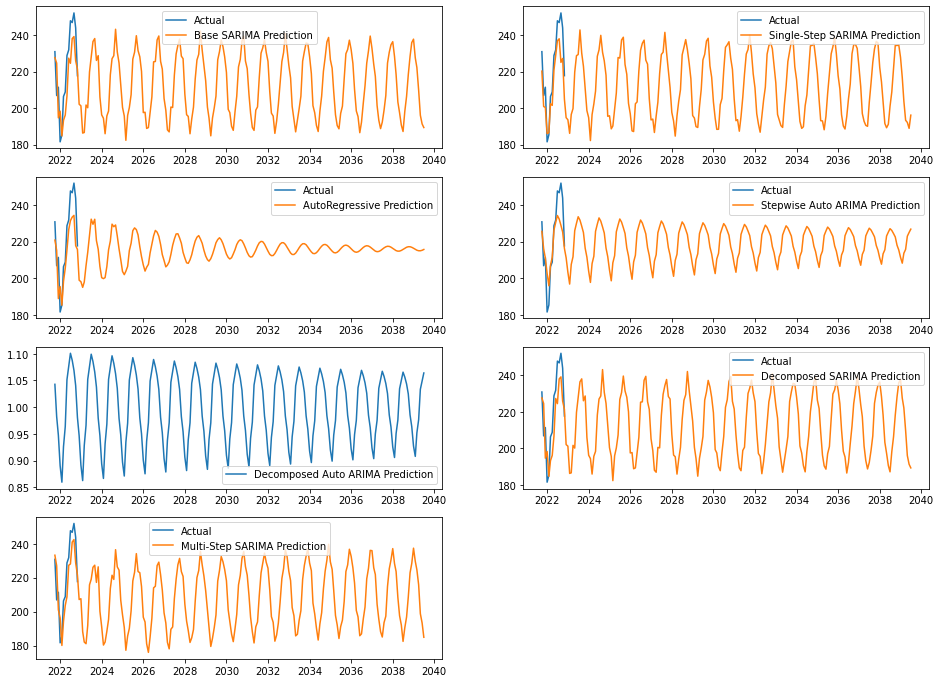

In [95]:
from matplotlib import pyplot as PLT
plt.rcParams["figure.figsize"] = (16,12)

fig = PLT.figure()

ax1 = fig.add_subplot(421)
ax1.plot(ts_test, label='Actual')
ax1.plot(base_sarima_forecast, label='Base SARIMA Prediction')
ax1.legend()

ax2 = fig.add_subplot(422)
ax2.plot(ts_test, label='Actual')
ax2.plot(single_step_forecast, label='Single-Step SARIMA Prediction')
ax2.legend()

ax3 = fig.add_subplot(423)
ax3.plot(ts_test, label='Actual')
ax3.plot(ar_forecast, label='AutoRegressive Prediction')
ax3.legend()

ax4 = fig.add_subplot(424)
ax4.plot(ts_test, label='Actual')
ax4.plot(stepwise_forecast, label='Stepwise Auto ARIMA Prediction')
ax4.legend()

ax5 = fig.add_subplot(425)
ax5.plot(seasonal_forecast, label='Decomposed Auto ARIMA Prediction')
ax5.legend()

ax6 = fig.add_subplot(426)
ax6.plot(ts_test, label='Actual')
ax6.plot(seasonal_sarima_forecast, label='Decomposed SARIMA Prediction')
ax6.legend()

ax7 = fig.add_subplot(427)
ax7.plot(ts_test, label='Actual')
ax7.plot(multi_seasonal_forecast, label='Multi-Step SARIMA Prediction')
ax7.legend()

PLT.show()

*    The Stepwise Auto Arima model performed the best in prediction but the forecast indicates the contrary, this leads to believe that the model performs poorly for long-term forecasting. 

*    The AutoRegressive model indicates the same with poor long-term forecasting as did the Stepwise Auto ARIMA model. 

*    The Seasonal SARIMA and Multi-Step SARIMA provided good forecasts that ranged similar to the original data.

*    The Base SARIMA and and Single-Step SARIMA best reflect long-term relationship with forecasting that reflect the cyclical three year pattern, buth the Single-Setp Multi-Step SARIMA accounted for seasonal trend the best and capture a near perfect SMAPE (0.10%). 

# Conclusion

Crime analysis has exploded among data analysts, data scientists, and enthusiasts recently. This project used Time Series models to predict and forecast crime in the City of Detroit from 2017 until now. Several Time Series models were performed most notably AutoRegressive, Auto ARIMA, and SARIMA models. 

**In summary**,
*   Data was aggregated into daily crimes and then monthly crimes for analysis.
*   The autocorrelation and decomposition plot indicated seasonal trend among the data.
*   The Multi-Step SARIMA's explained the best variance in the data. This model outperforms the previous ones in terms of dependability and demonstrated superior for short-term forecasting.
*   The Stepwise Auto ARIMA model performed the well with the highest R^2 70.56%, lowest NRMSE of 16.74%, and a SMAPE of 4.02% but it failed to capture an accurate long-term forecast.
*   The Single-Step SARIMA model performed the best in terms of a nero zero SMAPE (0.10%), indicating that this was the ideal model for forecasting. 	

*Note: At the time of this analysis, 2022 has not concluded yet.*